# Kontrolna tačka 3 – Odabir algoritama, metrike, treniranje, validacija i testiranje + analiza rezultata

#1. Odabir algoritama i metrika uspešnosti

###1.1 Odabir algoritama


U okviru ovog rada primenjena je arhitektura duboke konvolucione neuronske mreže ResNet50, sa ciljem klasifikacije otpada na osnovu vizuelnih karakteristika slika. Model je implementiran korišćenjem pristupa transfer learning, pri čemu je mreža inicijalno pretrenirana na velikom ImageNet skupu podataka, a zatim dodatno prilagođena specifičnom problemu klasifikacije otpada.

ResNet50 predstavlja duboku arhitekturu sa 50 slojeva koja koristi rezidualne veze (residual connections) kako bi omogućila stabilno i efikasno treniranje veoma dubokih neuronskih mreža. Ovaj pristup rešava problem nestajanja gradijenta i omogućava modelu da uči složene i apstraktne vizuelne obrasce. Zahvaljujući velikom broju parametara i dubini mreže, ResNet50 je sposoban da prepozna kompleksne karakteristike slika, što je posebno značajno kod klasifikacije otpada gde određene kategorije mogu imati slične vizuelne osobine.

Iako model postiže visoke performanse, njegova kompleksnost može dovesti do pretreniranosti ukoliko podaci nisu dovoljno raznovrsni ili su nebalansirani. Zbog toga je posebna pažnja posvećena pretprocesiranju podataka i pravilnoj podeli skupa na trening, validacioni i test skup, kako bi se obezbedila što bolja generalizacija modela.


###1.2. Definisanje metrika uspešnosti

Korišćen je skup metrika koje omogućavaju sveobuhvatnu i objektivnu analizu performansi, posebno imajući u vidu nebalansiranu raspodelu klasa u datasetu.

**Accuracy** predstavlja odnos između broja ispravno klasifikovanih uzoraka i ukupnog broja uzoraka. Ova metrika daje osnovni uvid u ukupnu tačnost modela, ali sama po sebi može biti varljiva u slučaju nebalansiranih podataka, jer visoka tačnost može biti postignuta favorizovanjem dominantnih klasa. Zbog toga se accuracy koristi kao dopunska, a ne jedina metrika evaluacije.

**Precision** meri koliki procenat instanci koje je model predvideo kao pripadajuće određenoj klasi zaista pripada toj klasi. Ova metrika je posebno važna u kontekstu klasifikacije otpada, jer pokazuje pouzdanost modela prilikom donošenja odluke i smanjuje broj pogrešnih klasifikacija, naročito kod vizuelno sličnih kategorija.

**Recall** predstavlja sposobnost modela da prepozna sve instance određene klase. Ova metrika je značajna jer ukazuje na to koliko često model uspeva da detektuje određenu vrstu otpada, što je naročito važno za slabije zastupljene klase koje bi mogle biti zanemarene u procesu treniranja.

**F1-score** je harmonijska sredina precision i recall metrika i predstavlja balansiranu meru performansi modela. Ova metrika je naročito pogodna za nebalansirane skupove podataka, jer istovremeno uzima u obzir i tačnost i potpunost klasifikacije. U ovom radu korišćen je i ponderisani (weighted) F1-score, koji dodatno uzima u obzir različit broj uzoraka po klasama.

**Confusion Matrix** korišćena je kao vizuelni alat za detaljnu analizu grešaka modela po klasama. Ona omogućava uvid u to koje klase se najčešće mešaju, što je od posebnog značaja za analizu sličnih kategorija poput različitih vrsta stakla ili metala.


#2. Podela skupa podataka na trening, validacioni i test skup, pretprocesiranje slika

Cilj ovog koraka je da se podaci podele na train, validation i test skup u odnosu 70% / 15% / 15%, što je standardna praksa u mašinskom učenju.

Za svaku klasu se učitava lista slika, zatim se slike nasumično mešaju (random.shuffle) kako bi se izbegla pristrasnost, a onda se zračunavaju granice za train, validation i test skup na osnovu definisanih proporcija.

Za svaku od tri podele kreiraju se odgovarajući poddirektorijumi (npr. train/plastic, val/plastic, test/plastic), a slike se fizički kopiraju u njih pomoću shutil.copy. Na ovaj način se dobija jasno strukturiran dataset koji je kompatibilan sa Keras/TensorFlow alatima za učitavanje slika.

In [ ]:
import zipfile
from google.colab import files
import os
uploaded = files.upload()

destination_folder = '/content/'
# Kreiranje destinacionog foldera ako ne postoji
os.makedirs(destination_folder, exist_ok=True)

# Raspakivanje zip fajla
try:
  for fn in uploaded.keys():
    with zipfile.ZipFile(fn, 'r') as zip_ref:
      zip_ref.extractall(destination_folder)
    print(f'Uspešno raspakovano')
except zipfile.BadZipFile:
  print(f'Greška - nije validan zip fajl.')
except Exception as e:
  print(f'Došlo je do greške prilikom raspakivanja "{fn}": {e}')

Saving Garbage_Classification.zip to Garbage_Classification.zip
Uspešno raspakovano


In [ ]:
import os
import shutil
import random

# Putanje
BASE_DATASET_DIR = "/content/garbage_classification"
SPLIT_DIR = "/content/data_split"

# Proporcije podele
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Reproduktivnost
random.seed(42)

# Kreiranje osnovnih foldera
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(SPLIT_DIR, split), exist_ok=True)

# Podela podataka po klasama
for class_name in os.listdir(BASE_DATASET_DIR):
    class_path = os.path.join(BASE_DATASET_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    train_end = int(TRAIN_RATIO * len(images))
    val_end = train_end + int(VAL_RATIO * len(images))

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in splits.items():
        split_class_dir = os.path.join(SPLIT_DIR, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for file in files:
            shutil.copy(
                os.path.join(class_path, file),
                os.path.join(split_class_dir, file)
            )

print("Dataset uspešno podeljen na train / validation / test.")


Dataset uspešno podeljen na train / validation / test.


Nakon podele dataset-a izvršena je verifikacija broja uzoraka po klasama i skupovima (train/validation/test) kako bi se proverila ispravnost i ravnomernost podele.

In [ ]:
# provera podele
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()} SET:")
    total = 0
    for cls in os.listdir(os.path.join(SPLIT_DIR, split)):
        count = len(os.listdir(os.path.join(SPLIT_DIR, split, cls)))
        total += count
        print(f"  {cls}: {count}")
    print("  Ukupno:", total)



TRAIN SET:
  white-glass: 542
  shoes: 1383
  green-glass: 440
  cardboard: 623
  paper: 735
  brown-glass: 424
  plastic: 605
  clothes: 3727
  battery: 661
  metal: 538
  biological: 689
  trash: 487
  Ukupno: 10854

VAL SET:
  white-glass: 116
  shoes: 296
  green-glass: 94
  cardboard: 133
  paper: 157
  brown-glass: 91
  plastic: 129
  clothes: 798
  battery: 141
  metal: 115
  biological: 147
  trash: 104
  Ukupno: 2321

TEST SET:
  white-glass: 117
  shoes: 298
  green-glass: 95
  cardboard: 135
  paper: 158
  brown-glass: 92
  plastic: 131
  clothes: 800
  battery: 143
  metal: 116
  biological: 149
  trash: 106
  Ukupno: 2340


**Pretprocesiranje i augmentacija podataka** su ključni koraci za treniranje dubokih neuronskih mreža. Normalizacija i augmentacija omogućavaju modelu da bolje uči vizuelne karakteristike, smanjujući rizik od overfitting-a i povećavajući tačnost na realnim podacima.


Za trening skup se primenjuje augmentacija, kako bi model video različite varijacije istih klasa.

Za validacioni i test skup se primenjuje samo normalizacija. Ovo je važno da bi evaluacija bila realna i nepristrasna, odnosno da model ne vidi izmenjene podatke na kojima ne treba da generalizuje.

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SPLIT_DIR = "/content/data_split"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_test_datagen = ImageDataGenerator(rescale=1./255)


Za treniranje, validaciju i testiranje modela korišćeni su **ImageDataGenerator objekti** koji omogućavaju učitavanje slika direktno sa diska u batch-evima. Generator automatski dodeljuje label-e na osnovu imena foldera i omogućava direktno povezivanje sa Keras modelom.

Generatori štede memoriju tako što učitavaju slike batch-po-batch, automatski pripremaju label-e, omogućavaju augmentaciju na trening skupu i pogodni su za direktno korišćenje sa Keras .fit() funkcijom.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(SPLIT_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 10854 images belonging to 12 classes.
Found 2321 images belonging to 12 classes.
Found 2340 images belonging to 12 classes.


# 3. ResNet50 Model

###3.1. Ključne karakteristike


**50 slojeva duboke arhitekture** koja može učiti
hijerarhijske reprezentacije slika, od osnovnih karakteristika (ivice, teksture) do kompleksnih obrazaca (oblici objekata).

**Residual veze** (skip connections) omogućavaju da gradient prolazi kroz mrežu bez gubitka, čime se olakšava treniranje dubokih modela.

In [ ]:
# definisanje resnet modela
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Broj klasa
num_classes = len(train_generator.class_indices)  # 12

# Učitavanje ResNet50 bez top sloja, sa pretreniranom težinom (ImageNet)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,  # uklanjamo originalni classifier
    input_shape=(224, 224, 3)
)

# Zamrzavamo osnovne slojeve (freeze)
base_model.trainable = False

# Dodajemo svoj classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # smanjuje dimenzije
x = Dropout(0.3)(x)              # regularizacija
outputs = Dense(num_classes, activation='softmax')(x)

# Definišemo kompletan model
model = Model(inputs=base_model.input, outputs=outputs)

# Kompajliramo model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Pregled modela
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Broj epoha
epochs = 20

# Treniranje modela
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)


Epoch 1/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 180s 530ms/step - accuracy: 0.6085 - loss: 1.1796 - val_accuracy: 0.4920 - val_loss: 3.0254
Epoch 2/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 151s 444ms/step - accuracy: 0.6178 - loss: 1.1895 - val_accuracy: 0.4317 - val_loss: 5.1346
Epoch 3/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 150s 440ms/step - accuracy: 0.6287 - loss: 1.1321 - val_accuracy: 0.5213 - val_loss: 1.7397
Epoch 4/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 149s 438ms/step - accuracy: 0.6268 - loss: 1.1557 - val_accuracy: 0.2714 - val_loss: 3.7184
Epoch 5/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 152s 446ms/step - accuracy: 0.6384 - loss: 1.0975 - val_accuracy: 0.4752 - val_loss: 3.2729
Epoch 6/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 149s 438ms/step - accuracy: 0.6561 - loss: 1.0728 - val_accuracy: 0.3343 - val_loss: 4.7379
Epoch 7/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 147s 431ms/step - accuracy: 0.6496 - loss: 1.0797 - val_accuracy: 0.4403 - val_loss: 5.1802
Epoch 8/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 148s 436ms/step - accuracy: 0.6570 -

Nakon inicijalnog treniranja ResNet50, izvršen je **fine-tuning** poslednjih 10 slojeva. Slojevi su otključani i model je ponovno kompajliran sa manjim learning rate (1e-5) kako bi se sačuvalo prethodno znanje iz ImageNet-a. Model je zatim treniran dodatnih 10 epoha, čime se poboljšala sposobnost prepoznavanja specifičnih karakteristika klasa otpada i postigla stabilnija evaluacija.

Prethodno su svi slojevi bili zamrznuti (trainable=False) da bi se iskoristilo pretrenirano znanje. Otvaranjem slojeva omogućavamo modelu da prilagodi ove slojeve našem dataset-u i nauči specifične karakteristike naših slika (npr. teksture različitih tipova otpada).

In [ ]:
# Otključavanje poslednjih 10 slojeva ResNet50
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Ponovno kompajliranje sa manjim learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Dodatne epohe
fine_tune_epochs = 10

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    verbose=1
)


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 174s 472ms/step - accuracy: 0.7085 - loss: 0.8766 - val_accuracy: 0.7165 - val_loss: 0.8714
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 150s 440ms/step - accuracy: 0.7206 - loss: 0.8450 - val_accuracy: 0.7243 - val_loss: 0.8551
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 146s 428ms/step - accuracy: 0.7203 - loss: 0.8529 - val_accuracy: 0.7225 - val_loss: 0.8527
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 154s 452ms/step - accuracy: 0.7282 - loss: 0.8285 - val_accuracy: 0.7312 - val_loss: 0.8354
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 147s 432ms/step - accuracy: 0.7301 - loss: 0.8213 - val_accuracy: 0.7286 - val_loss: 0.8426
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 147s 432ms/step - accuracy: 0.7395 - loss: 0.8271 - val_accuracy: 0.7324 - val_loss: 0.8321
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 146s 429ms/step - accuracy: 0.7385 - loss: 0.8107 - val_accuracy: 0.7312 - val_loss: 0.8318
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 152s 448ms/step - accuracy: 0.7373 -

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")



74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.7587 - loss: 0.8054
Test loss: 0.8769
Test accuracy: 0.7338


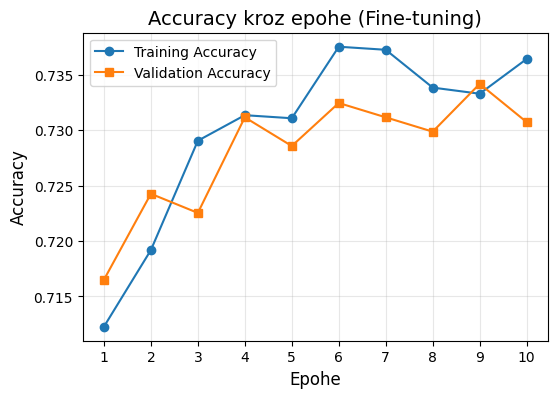

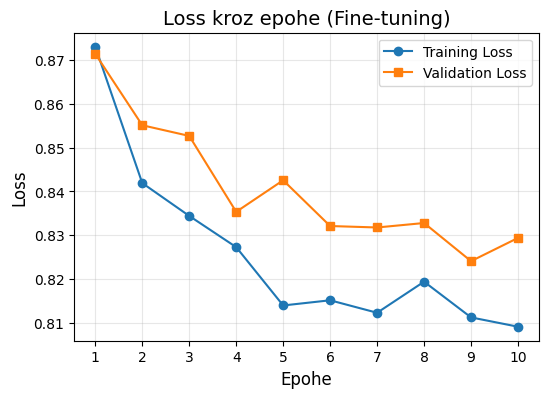

In [ ]:
import matplotlib.pyplot as plt

# Podaci iz fine-tuning faze
fine_acc = history_fine.history['accuracy']
fine_val_acc = history_fine.history['val_accuracy']

fine_loss = history_fine.history['loss']
fine_val_loss = history_fine.history['val_loss']

epochs_range = range(1, len(fine_acc) + 1)  # prikazuje epohe od 1, a ne 0

# ====== ACCURACY ======
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, fine_acc, marker='o', label='Training Accuracy')
plt.plot(epochs_range, fine_val_acc, marker='s', label='Validation Accuracy')
plt.xlabel('Epohe', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy kroz epohe (Fine-tuning)', fontsize=14)
plt.xticks(epochs_range)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ====== LOSS ======
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, fine_loss, marker='o', label='Training Loss')
plt.plot(epochs_range, fine_val_loss, marker='s', label='Validation Loss')
plt.xlabel('Epohe', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss kroz epohe (Fine-tuning)', fontsize=14)
plt.xticks(epochs_range)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step
========== EVALUACIJA RESNET50 MODELA ==========

Izveštaj o klasifikaciji:

              precision    recall  f1-score   support

     battery       0.68      0.80      0.73       143
  biological       0.85      0.59      0.70       149
 brown-glass       0.64      0.49      0.56        92
   cardboard       0.69      0.70      0.70       135
     clothes       0.88      0.95      0.91       800
 green-glass       0.73      0.55      0.63        95
       metal       0.52      0.48      0.50       116
       paper       0.57      0.68      0.62       158
     plastic       0.49      0.41      0.45       131
       shoes       0.72      0.78      0.75       298
       trash       0.76      0.58      0.66       106
 white-glass       0.46      0.44      0.45       117

    accuracy                           0.73      2340
   macro avg       0.67      0.62      0.64      2340
weighted avg       0.73      0.73      0.73      2340

Accuracy: 0.73

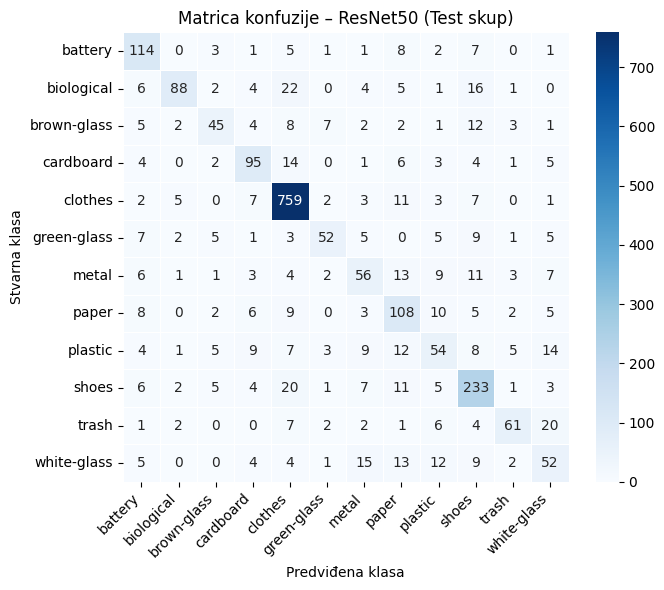

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)

test_generator.reset()
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predikcije modela
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

print("========== EVALUACIJA RESNET50 MODELA ==========\n")

# 1. Classification Report
print("Izveštaj o klasifikaciji:\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_labels
    )
)

# 2. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 3. Macro F1-score
macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1-score: {macro_f1:.4f}")

# 4. Weighted F1-score
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Weighted F1-score: {weighted_f1:.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5
)

plt.xlabel("Predviđena klasa")
plt.ylabel("Stvarna klasa")
plt.title("Matrica konfuzije – ResNet50 (Test skup)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




# 4. EfficientNetB0 Model


Pored ResNet50 arhitekture, testirana je i EfficientNet arhitektura, koja koristi skaliranje dubine, širine i rezolucije na efikasniji način.
EfficientNet je porodica konvolucionih neuronskih mreža koje su dizajnirane da postignu visoku tačnost uz manje parametara i nižu računarsku složenost u poređenju sa tradicionalnim dubokim mrežama poput ResNet-a.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Parametri
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 12


In [ ]:
# Učitavanje EfficientNetB0
base_modele = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_modele.trainable = False  # zamrzavanje slojeva za inicijalno treniranje

# Dodavanje GlobalAveragePooling + Dense slojeva
x = base_modele.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Kreiranje modela
modele = Model(inputs=base_modele.input, outputs=output)

# Pregled modela
modele.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,380,591 (16.71 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Kompajliranje
modele.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treniranje samo klasifikacionog sloja
history_initiale = modele.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # inicijalne epohe
    verbose=1
)

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 185s 484ms/step - accuracy: 0.3317 - loss: 2.2261 - val_accuracy: 0.3438 - val_loss: 2.1884
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - accuracy: 0.3411 - loss: 2.1928 - val_accuracy: 0.3438 - val_loss: 2.1796
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 142s 418ms/step - accuracy: 0.3528 - loss: 2.1635 - val_accuracy: 0.3438 - val_loss: 2.1818
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 423ms/step - accuracy: 0.3430 - loss: 2.1796 - val_accuracy: 0.3438 - val_loss: 2.1802
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 424ms/step - accuracy: 0.3396 - loss: 2.1880 - val_accuracy: 0.3438 - val_loss: 2.1837
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 141s 416ms/step - accuracy: 0.3449 - loss: 2.1751 - val_accuracy: 0.3438 - val_loss: 2.1780
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 421ms/step - accuracy: 0.3445 - loss: 2.1816 - val_accuracy: 0.3438 - val_loss: 2.1789
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 422ms/step - accuracy: 0.3463 -

In [ ]:
# Otključavanje poslednjih 20 slojeva EfficientNet
for layer in base_modele.layers[-20:]:
    layer.trainable = True

# Ponovno kompajliranje sa manjim learning rate
modele.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_finee = modele.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # dodatne epohe
    verbose=1
)

Epoch 1/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 195s 495ms/step - accuracy: 0.3130 - loss: 2.2913 - val_accuracy: 0.3438 - val_loss: 2.1896
Epoch 2/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 145s 426ms/step - accuracy: 0.3469 - loss: 2.1748 - val_accuracy: 0.3438 - val_loss: 2.1804
Epoch 3/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 146s 428ms/step - accuracy: 0.3427 - loss: 2.1738 - val_accuracy: 0.3438 - val_loss: 2.1773
Epoch 4/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 145s 428ms/step - accuracy: 0.3472 - loss: 2.1614 - val_accuracy: 0.3438 - val_loss: 2.1732
Epoch 5/5
340/340 ━━━━━━━━━━━━━━━━━━━━ 144s 422ms/step - accuracy: 0.3393 - loss: 2.1758 - val_accuracy: 0.3438 - val_loss: 2.1677


In [ ]:
# Evaluacija modela na test podacima
test_loss, test_acc = modele.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.3335 - loss: 2.2217
Test accuracy: 0.3419
